# Data preprocessing

CML and ref wet/dry data loading, inspecting, preprocessing and building dataset.  

__CML data:__  
Imported from pycomlink (Chwala C:): https://github.com/pycomlink/pycomlink

__Sources: Inspired by__  
Pytorch CML w/d - github: https://github.com/jpolz/cml_wd_pytorch/tree/main  
Pycomlink - github: https://github.com/pycomlink/pycomlink/tree/master  
thesis: https://doi.org/10.5194/amt-13-3835-2020 [2]  

In [1]:
import xarray as xr               # work with arrays, also possible with pandas
import pandas as pd
import numpy as np
#import torch
#import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
#from sklearn.utils import shuffle
#from tqdm import tqdm
#from IPython.display import clear_output

#### Load data
Import data of 500 CML links from pycomlink with 1min timestep.  
Reference path averaged RADOLAN rain rate data aligned with all 500 CML IDs with 5 min time step.

In [38]:
# 500 CMLs with 1 min time step
cml_set = xr.open_dataset('example_data/example_cml_data.nc', engine='netcdf4') # https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html
# reference RADOLAN 5 min time step
ref_set = xr.open_dataset('example_data/example_path_averaged_reference_data.nc', engine='netcdf4')
ref_set = ref_set.rename_vars({'rainfall_amount':'rain'})

In [70]:
# Choose one cml
k = 50; # index of chosen cml 0-499

my_cml = cml_set.isel(cml_id = k) # https://docs.xarray.dev/en/latest/generated/xarray.Dataset.assign.html
my_ref = ref_set.isel(cml_id = k)

# Check for fault data in TSL, RSL and replace it with NaN https://github.com/jpolz/cml_wd_pytorch/tree/main
my_cml['tsl'] = my_cml.tsl.where(my_cml.tsl != 255.0)
my_cml['rsl'] = my_cml.rsl.where(my_cml.rsl != -99.9)

# Calculate TRSL
my_cml['trsl'] = my_cml.tsl - my_cml.rsl

# Iterpolate missing values: From pycomlink
my_cml['trsl'] = my_cml.trsl.interpolate_na(dim='time', method='linear', max_gap='5min')
my_ref['rain'] = my_ref.rain.interpolate_na(dim='time', method='linear', max_gap='5min')


In [71]:
ds = my_cml.assign(my_ref)

# From reference rain rate derivate boolean reference Wet/Dry signal
ds['ref_wd'] = my_ref.rain.where(my_ref.rain == 0, True) # ChatGPT
ds['rain'][-1] = 0
ds['ref_wd'][-1] = 0

ds['rain'] = ds.rain.interpolate_na(dim='time', method='linear', max_gap='5min')
ds['ref_wd'] = ds.ref_wd.interpolate_na(dim='time', method='nearest', max_gap='5min')
#my_data_set['ref_wet_dry'] = my_ref.rainfall_amount.where(my_ref.rainfall_amount == 0, True) # ChatGPT
# convert float value to bool for plotting the shaded areas from Pycomlink
ds['ref_wd'] = ds.fillna(0).ref_wd.astype(bool)

#### Plot and inspect the data

Text(0.5, 1.0, '')

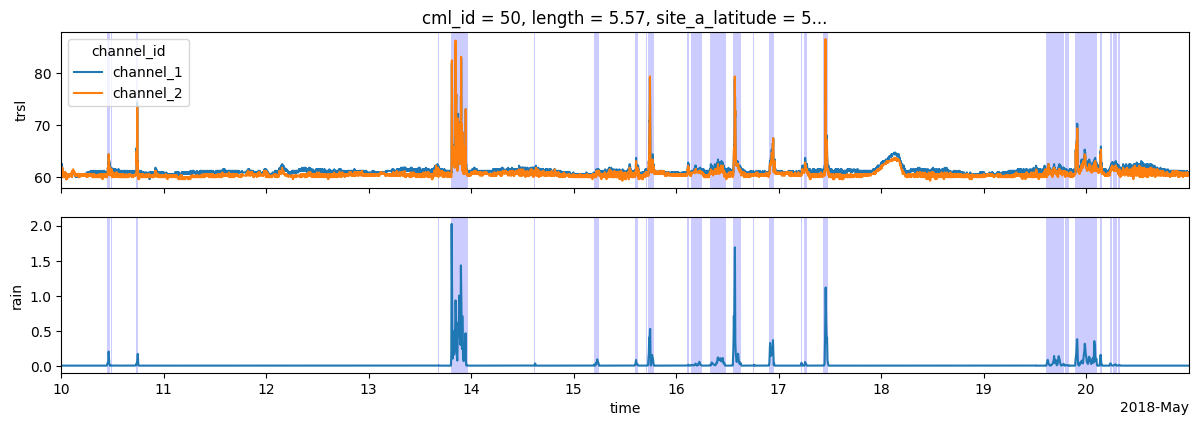

In [72]:
# shaded refernece wet periods from Pycomlink
# set first and last value with zero for correct plotting
ds['ref_wd'][0] = False
ds['ref_wd'][-1] = False

# setup figure
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12,4))
fig.tight_layout()

# plot TRSL
ds.trsl.plot.line(x='time', ax=axs[0], label = 'TL');
# plot Rain rate 
ds.rain.plot.line(x='time', ax=axs[1], label = 'TL');

# plot real bool wet/dry with 5min precission
wet_start = np.roll(ds.ref_wd, -1) & ~ds.ref_wd
wet_end = np.roll(ds.ref_wd, 1) & ~ds.ref_wd
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    axs[0].axvspan(ds.time.values[wet_start_i], ds.ref_wd.time.values[wet_end_i], color='b', alpha=0.2, linewidth=0); # https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.axvspan.html
    axs[1].axvspan(ds.time.values[wet_start_i], ds.ref_wd.time.values[wet_end_i], color='b', alpha=0.2, linewidth=0); # https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.axvspan.html
   

# axes limits source: https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xlim.html
axs[1].set_xlim(ds.time.values[0], ds.time.values[-1])
axs[0].set_xlabel('')
axs[1].set_title("")


In [74]:
cml_set

<xarray.Dataset> Size: 254MB
Dimensions:           (time: 15840, cml_id: 500, channel_id: 2)
Coordinates:
  * time              (time) datetime64[ns] 127kB 2018-05-10 ... 2018-05-20T2...
  * cml_id            (cml_id) <U3 6kB '0' '1' '2' '3' ... '497' '498' '499'
    length            (cml_id) float64 4kB ...
    site_a_latitude   (cml_id) float64 4kB ...
    site_a_longitude  (cml_id) float64 4kB ...
    site_b_latitude   (cml_id) float64 4kB ...
    site_b_longitude  (cml_id) float64 4kB ...
  * channel_id        (channel_id) <U9 72B 'channel_1' 'channel_2'
    frequency         (cml_id, channel_id) float64 8kB ...
    polarization      (cml_id, channel_id) <U1 4kB ...
Data variables:
    rsl               (channel_id, cml_id, time) float64 127MB ...
    tsl               (channel_id, cml_id, time) float64 127MB ...

#### <span style="color:red">TODO: </span>Detect higher fault periods

#### <span style="color:red">TODO: </span>Export dataset